<h1><b>Άσκηση 2</b></h1>
<p align="justify">Σας δίνεται η παρακάτω στοχαστική μήτρα πιθανοτήτων P μιας μαρκοβιανής αλυσίδας. Από τη μήτρα αυτή έχουν παραλειφθεί ορισμένα στοιχεία:</p>
<img src="https://raw.githubusercontent.com/nkostopoulos/StochasticsLabPublic/master/lab3/ex2.PNG"><img>
<ul>
<li>Να συμπληρώσετε τα κενά της μήτρας πιθανοτήτων P της μαρκοβιανής αλυσίδας.</li>
<li>Χρησιμοποιώντας τον <a href="http://setosa.io/markov/index.html#%7B%22tm%22%3A%5B%5B0.6%2C0.2%2C0%2C0%2C0%2C0.2%5D%2C%5B0.2%2C0.6%2C0.2%2C0%2C0%2C0%5D%2C%5B0%2C0.2%2C0.6%2C0.2%2C0%2C0%5D%2C%5B0%2C0%2C0.2%2C0.6%2C0.2%2C0%5D%2C%5B0%2C0%2C0%2C0.2%2C0.6%2C0.2%5D%2C%5B0.2%2C0%2C0%2C0%2C0.2%2C0.6%5D%5D%7D">προσομοιωτή</a> να σχεδιάσετε την παραπάνω μαρκοβιανή αλυσίδα και να ταξινομήσετε τις καταστάσεις της σε κλάσεις επικοινωνίας. Πώς αποκαλείται μια τέτοια αλυσίδα με κριτήριο τις κλάσεις επικοινωνίας; Τι συμπέρασμα βγάζετε σχετικά με την ύπαρξη αναλλοίωτης κατανομής για την αλυσίδα;</li>
<li>Χρησιμοποιώντας τον κώδικα που παρατίθεται στο τέλος της άσκησης θα εκτιμήσετε την αναλλοίωτη κατανομή της μαρκοβιανής αλυσίδας με τη μέθοδο της προσομοίωσης. Το πρόγραμμα: (α) ορίζει τη μήτρα πιθανοτήτων και την αρχική κατανομή της αλυσίδας, (β) ορίζει το μοντέλο της και (γ) εκτιμά την αναλλοίωτη κατανομή της αλυσίδας για κάθε κατάσταση, διαιρώντας τον αριθμό των επισκέψεων στην κατάσταση αυτή με το συνολικό αριθμό των βημάτων της αλυσίδας (παράμετρος <i>total_runs</i>). Το πρόγραμμα δίνει ως έξοδο ένα ραβδόγραμμα που απεικονίζει την αναλλοίωτη κατανομή της αλυσίδας. Να καταγράψετε το αποτέλεσμα της εκτέλεσης του προγράμματος για συνολικό αριθμό βημάτων της αλυσίδας (α) 500, (β) 1,000, (γ) 10,000, (δ) 100,000, (ε) 1,000,000, (στ) 10,000,000 και (ζ) 100,000,000. Πόσο μεταβάλεται η εκτίμηση ανάμεσα σε κάθε έξοδο; Τι παρατηρείτε σχετικά με το συνολικό χρόνο εκτέλεσης της προσομοίωσης ανάλογα με το συνολικό αριθμό βημάτων της αλυσίδας; Κατά τη γνώμη σας, ποια τιμή του συνολικού αριθμού των βημάτων της αλυσίδας επιτυγχάνει μια ικανοποιητική ισορροπία ανάμεσα στην ακρίβεια του αποτελέσματος και το συνολικό χρόνο εκτέλεσης της προσομοίωσης; <b>Για να τρέξετε το πρόγραμμα θα πρέπει να έχετε φορτώσει το αρχείο <i><a href="https://github.com/nkostopoulos/StochasticsLabPublic/blob/master/lab3/simple_markov_chain_lib.py">simple_markov_chain_lib.py</a></i>.</b></li>
<li>Τι παρατηρείτε σχετικά με τις τιμές της αναλλοίωτης κατανομής της παραπάνω μαρκοβιανής αλυσίδας; Να υπολογίσετε το άθροισμα των στοιχείων κάθε στήλης της μήτρας πιθανοτήτων <b>P</b>. Πώς ονομάζεται μία τέτοια μήτρα πιθανοτήτων και τι ισχύει για την αναλλοίωτη κατανομή μιας τέτοιας αλυσίδας;</li>


In [1]:
#@title
from bisect import bisect_left
from random import random

import networkx as nx  # get communication classes
import numpy as np
from scipy.sparse import csr_matrix


class markov_chain:

    def __init__(self, markov_table, init_dist=None):
        """
        Constructs a Markov Chain from a transition matrix.
        The initial distribution can be provided or setted aftewards.
        """

        # Attributes
        self.running_state = None
        self.steps = 0
        self.visits = {state: 0 for state in markov_table}
        size = len(markov_table)

        # Set up state transition probs
        self._states = {state: self._partial_sums(dist)
                        for state, dist in markov_table.items()}
        for state, dist in self._states.items():
            if not np.isclose(dist[-1][0], 1.0):
                msg = "State {} transitions do not add up to 1.0".format(state)
                raise ValueError(msg)
        self._probs_state = np.array([0] * size)

        # Adjacency Matrix
        data, rows, cols = [], [], []
        for row, dist in markov_table.items():
            col, pval = zip(*[(s, p) for s, p in dist.items() if p > 0])
            rows += [row] * len(col)
            cols += col
            data += pval
        # make sure they are in the right order
        enum = {state: i for i, state in enumerate(self._states)}
        rows = [enum[r] for r in rows]
        cols = [enum[c] for c in cols]
        self._adj = csr_matrix((data, (rows, cols)), shape=(size, size))

        # Communication Classes
        classes = {'Closed': [], 'Open': []}
        g = nx.MultiDiGraph(self._adj)
        scc = list(nx.strongly_connected_components(g))
        g = nx.condensation(g)  # SCCs collapse to single nodes
        for n in g:
            if g.out_degree(n) == 0:
                classes["Closed"].append(scc[n])
            else:
                classes["Open"].append(scc[n])
        self.communication_classes = classes

        # Set Initial State
        self._init_dist = None
        if init_dist is not None:
            self.init_dist = init_dist

    def __len__(self):
        """The cardinality of the state-space"""
        return len(self._states)

    @property
    def probs_matrix(self):
        """The transition probability matrix"""
        return self._adj.toarray()

    @property
    def probs_state(self):
        """
        Computes analytically the probability of being in every state at
        currentn step. Returns a vector of state probabilities
        """
        init_dist = np.array([self.init_dist.get(state, 0.0)
                              for state in self._states])
        probs = init_dist @ (self._adj ** self.steps)
        return dict(zip(self._states, probs))

    @property
    def init_dist(self):
        """The initial distribution of the chain"""
        return self._init_dist

    @init_dist.setter
    def init_dist(self, dist):
        if not np.isclose(sum(dist.values()), 1.0):
            msg = "The transition probabilities of init_dist must add up to 1.0"
            raise ValueError(msg)
        self._init_dist = dist
        self._state0 = self._partial_sums(dist)
        self.running_state = None

    @property
    def eigenvalues(self):
        """Returns the eigenvalues of the transition table"""
        return list(np.sort(np.linalg.eigvals(self.probs_matrix)))

    def _partial_sums(self, dist):
        """
        Takes as input a row of the probability matrix (dist)
        and generates its partial sums.
        These are cached as tuples (sum, state) to be sampled.
        """
        states, probs = zip(*[(s, p) for s, p in dist.items() if p > 0])
        probs = np.cumsum(probs)
        return list(zip(probs, states))

    def _next_state(self, state):
        """Selects a new state based on the transition probabilities"""
        return state[bisect_left(state, (random(), ))][1]

    def start(self):
        """First step of the chain choosen from the initial distribution"""

        # Initiate walk
        self.steps = 0
        for state in self._states:
            self.visits[state] = 0

        # Initialize the state distribution - to be updated as we walk
        self.running_state = self._next_state(self._state0)
        self.visits[self.running_state] = 1

    def move(self):
        """Moves to the next state and updates all relevant fields"""
        transition_probs = self._states[self.running_state]
        self.running_state = self._next_state(transition_probs)
        self.steps += 1
        self.visits[self.running_state] += 1



0:  0.166459
1:  0.166669
2:  0.167568
3:  0.166968
4:  0.166239
5:  0.166097


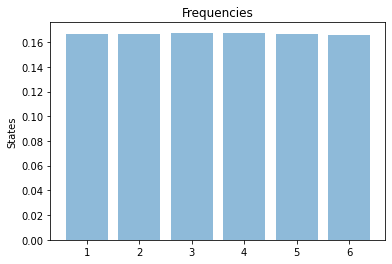

In [12]:
from __future__ import division
#from simple_markov_chain_lib import markov_chain
import numpy as np
import matplotlib.pyplot as plt

def defineMarkovTable(): 
	markov_table = {
		0: {0: 0.6, 1: 0.2, 5: 0.2},
		1: {0: 0.2, 1: 0.6, 2: 0.2},
		2: {1: 0.2, 2: 0.6, 3: 0.2},
		3: {2: 0.2, 3: 0.6, 4: 0.2},
		4: {3: 0.2, 4: 0.6, 5: 0.2},
		5: {0: 0.2, 4: 0.2, 5: 0.6}
        }

	return markov_table

def defineInitDistribution():
	init_dist = {0: 1.}
	
	return init_dist

def calculateFrequencyTable(markov_table,init_dist):
	total_runs = 1000000

	visits = list()
	visits = [0] * len(markov_table)

	for index in range(total_runs):
		mc.move()
		visits[mc.running_state] += 1
	
	frequency = [v/total_runs for v in visits]
	
	return frequency

def printFrequencies(frequency, markov_table):
	for state in range(0, len(markov_table)) :
		print(str(state) + ": ", str(frequency[state]))
	
	return None

def plotFrequencies(frequency):
	objects = ('1', '2', '3', '4', '5', '6')
	y_pos = np.arange(len(objects))
	
	plt.bar(y_pos, frequency, align='center', alpha=0.5)
	plt.xticks(y_pos, objects)
	plt.ylabel('States')
	plt.title('Frequencies')
	plt.show()
	
	return None

if __name__ == "__main__":
	markov_table = defineMarkovTable()
	init_dist = defineInitDistribution()
	mc = markov_chain(markov_table, init_dist)
	mc.start()

	frequency = calculateFrequencyTable(markov_table, init_dist)
	printFrequencies(frequency, markov_table)
	plotFrequencies(frequency)

## Απαντήσεις



1.   Τα κενά συμπληρώνονται με κριτήριο οι γραμμές να αθροίζουν στην μονάδα
2.   Παρατηρούμε από την μήτρα μεταβάσεων αλλά και από την προσομοίωση ότι όλες οι καταστάσεις είναι επαναληπτικές και όλες επικοινωνούν με όλες δηλαδή ανήκουν στην ίδια κλάση επικοινωνίας, επομένως έχουμε μια μη υποβιβάσιμη αλυσίδα Markov. Παρατηρούμε επίσης ότι δεν έχουμε περιοδικότητα συνεπώς η αλυσίδα μας είναι εργοδική. Συνεπώς μπορούμε να έχουμε σύγκλιση σε αναλοίωτη κατανομή που θα περιλαμβάνει και τις 6 καταστάσεις.
3. Αρχικά ο χρόνος εκτέλεσης είναι 0 sec για 500,100,1000,10000,100000 βήματα. 1sec για 1000000 , 14sec για 10000000 και 2m17sec για 100000000. Παρατηρούμε κάποιες σημαντικές ποιοτικές αλλαγές μέχρι και τα 1000000 βήματα, ύστερα η αύξηση βημάτων δεν οδηγεί σε σημαντική βελτίωση των αποτελεσμάτων. Οπότε η επιλογή μας είναι τα 1000000 απο θέμα χρόνου/ποιότητας.
4. Παρατηρούμε ότι όλες οι Πιθανότητες Σταθερής Κατάστασης συγκλίνουν στο 1/6. Βλέπουμε ότι και οι στήλες αθροίζουν στην μονάδα. Στη περίπτωση αυτή η μήτρα ονομάζεται διπλά στοχαστική και έχουμε ίση πιθανότητα να βρεθούμε σε κάθε κατάσταση με το πέρας του μεταβατικού φαινομένου , δηλαδή για κάθε κατάσταση ισχύει π=1/6

